In [7]:
end = '2015-01-01'
start = '2007-01-01'
symbols = ['SPY','TLT','MSFT']
prices = ffn.get(symbols, start=start, end=end)

In [10]:
prices.pct_change()

,spy,tlt,msft
Date,,,
2007-01-03,NaN,NaN,NaN
2007-01-04,0.002122,0.006063,-0.001675
2007-01-05,-0.007976,-0.004353,-0.005703
2007-01-08,0.004626,0.001793,0.009784
2007-01-09,-0.000850,0.000000,0.001003
...,...,...,...
2014-12-24,0.000096,0.005443,-0.006399
2014-12-26,0.003225,0.003711,-0.005401
2014-12-29,0.001343,0.007475,-0.008981


# Time Series

A time series is a sequence where a metric is recorded over regular time intervals.

Depending on the frequency, a time series can be of yearly (annual budget), quarterly (expenses), monthly (air traffic), weekly (sales qty), daily (weather), hourly (stocks price), minutes (inbound calls in a call canter) or even seconds wise (web traffic).

It is very important to learn how to analyze a time series because it is the preparatory step before you develop a forecast of the series. Besides, time series forecasting has enormous commercial significance because stuff that is important to a business like demand and sales, number of visitors to a website, stock price etc are essentially time series data.
Time series analysis involves understanding various aspects about the inherent nature of the series so that you are better informed to create meaningful and accurate forecasts.

## Visualizing Time Series
The data for a time series typically stores in .csv files or other spreadsheet formats and contains two columns: the date and the measured value. Sometimes it may contains one or more related variables that are measured for the same time periods. 

Clearly the best instrument to deal with time series is the $\tt{pandas}$ package. In the following we are going to use a example dataset counting the total monthly scripts for pharmaceutical products falling under ATC code A10, \href{here}{a10.csv}. 

In [2]:
from dateutil.parser import parse 
import pandas as pd

df = pd.read_csv('a10.csv', 
                 parse_dates=['date'], index_col='date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value'):
    plt.figure(figsize=(10,8))
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, 
        title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')    

/home/sani/anaconda3/envs/.python3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 1000x800 with 1 Axes>

Since its a monthly time series and follows a certain repetitive pattern every year, you can plot each year as a separate line in the same plot. This lets you compare the year wise patterns side-by-side.

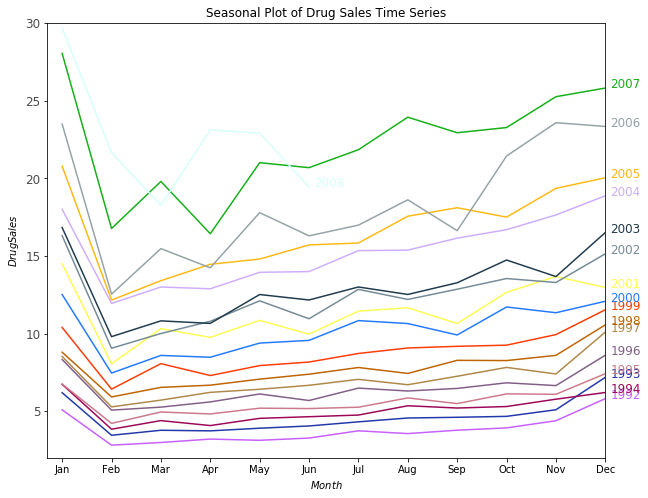

In [4]:
import numpy as np
df.reset_index(inplace=True)

df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), 
                            len(years), replace=False)

plt.figure(figsize=(10,8))
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], 
                 color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, 
                 df.loc[df.year==y, 'value'][-1:].values[0], y, 
                 fontsize=12, color=mycolors[i])

plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series")
plt.show()

There is a steep fall in drug sales every February, rising again in March, falling again in April and so on. Clearly, the pattern repeats within a given year, every year.

## Patterns in a time series
So far, we have seen the similarities to identify the pattern. Now, how to find out any deviations from the usual pattern?
Any time series may be split into the following components

* base Level;
* trend: is observed when there is an increasing or decreasing slope observed in the time series;
* seasonality: is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day;
* error.

It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true.
So, a time series may be imagined as a combination of the trend, seasonality and the error terms.

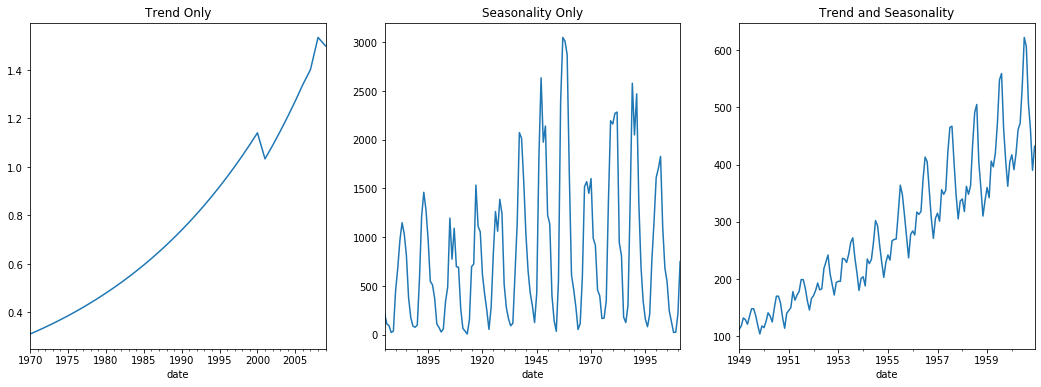

In [5]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', 
            parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', 
            parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', 
            parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

Another aspect to consider is the cyclic behaviour. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. Care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect. If the patterns are not of fixed calendar based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.

### Autoregression (AR)

A regression model, such as linear regression, models an output value based on a linear combination of input values (see CAPM discussion). For example:

$$\hat{y} = b_0 + b_1*X_1$$
where $\hat{y}$ is the prediction, $b_0$ and $b_1$ are coefficients found by optimizing the model on training data, and $X$ is an input value.

This technique can be used on time series where input variables are taken as observations at previous time steps, called \emph{lag variables}.

For example, we can predict the value for the next time step $(t+1)$ given the observations at the last two time steps ($t-1$ and $t-2$). As a regression model, this would look as follows:

$$X_{t+1} = b_0 + b_1*X_{t-1} + b_2*X_{t-2}$$

Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self).

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

A pure Auto Regressive (AR only) model is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the ‘lags of $Y_t$’.

$$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + \epsilon_t$$

where, $Y_{t-1}$ is the lag1 of the series, $\beta_1$ is the coefficient of lag1 that the model estimates and $\alpha$ is the intercept term, also estimated by the model.

The notation for the model involves specifying the order of the model $p$ as a parameter to the AR function, e.g. AR($p$). For example, AR(1) is a first-order autoregression model.

### Moving Average (MA)
The moving average (MA) models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.

A moving average model is different from calculating the moving average of the time series.

The notation for the model involves specifying the order of the model q as a parameter to the MA function, e.g. MA(q). For example, MA(1) is a first-order moving average model.

A pure Moving Average (MA only) model is one where $Y_t$ depends only on the lagged forecast errors.

$$Y_t = \mu + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \ldots + \phi_q \epsilon_{t-q}+ \epsilon_t$$
where the error terms are the errors of the autoregressive models of the respective lags. The errors $\epsilon_t$ and $\epsilon{t-1}$ are the errors from the following equations:

$$Y_t = \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_0 Y_{0} + \epsilon_t$$
$$Y_{t-1} = \beta_2 Y_{t-2} + \beta_3 Y_{t-3} + \ldots + \beta_0 Y_{0} + \epsilon_{t-1}$$

## Stationary and Non-Stationary Time Series
A stationary series is one where the values of the series is not a function of time.
That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. 
A stationary time series is lacking of seasonal effects too.

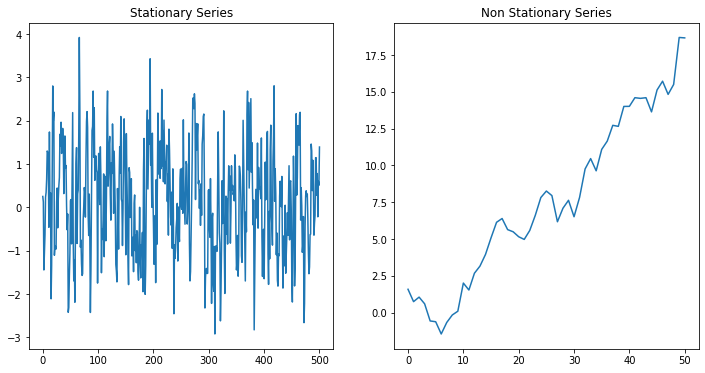

In [22]:
# plot of stationary and not stationary series
def f(x, phi):
    return phi*x + np.random.normal()

phi = 0.5
x = [f(1,phi)]
for _ in range(500):
    x.append(f(x[-1], phi))

phi = 1.051
x1 = [f(1,phi)]
for _ in range(50):
    x1.append(f(x1[-1], phi))
    
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Stationary Series")
plt.plot(x)
plt.subplot(1, 2, 2)
plt.title("Non Stationary Series")
plt.plot(x1)
plt.show()

### White Noise
White noise is particular example of stationary series. Its mean and variance does not change over time, the peculiarity is that the mean is constant at 0.

If you consider the sound signals in an FM radio as a time series, the blank sound you hear between the channels is white noise. Mathematically, a sequence of completely random numbers with mean zero is a white noise.

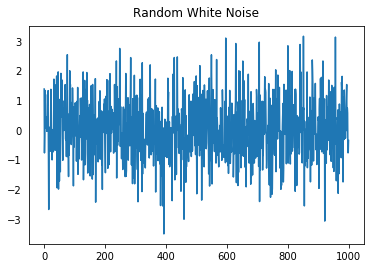

In [25]:
randvals = np.random.randn(1000)
plt.plot(randvals)
plt.title('Random White Noise')
plt.show()

### Making a Non Stationary Series Stationary
It is possible to make nearly any time series stationary by applying a suitable transformation. This is useful since most statistical forecasting methods are designed to work on a stationary time series.

You can make series stationary by:

* differencing the Series (once or more times);
* take the log of the series;
* take the nth root of the series;
* combination of the above.

The most common and convenient method to stationarize the series (and the only one we are going to look at) is by differencing the series at least once until it becomes approximately stationary.

If $Y_t$ is the value at time $t$, then the first difference of $Y = Y_t – Y_{t-1}$. In simpler terms, differencing the series is nothing but subtracting the next value by the current value.
If the first difference doesn’t make a series stationary, you can go for the second differencing. And so on.

For example, consider the following series: [1, 5, 2, 12, 20]
First differencing gives: [5-1, 2-5, 12-2, 20-12] = [4, -3, 10, 8]
Second differencing gives: [-3-4, -10-3, 8-10] = [-7, -13, -2]



SPOSTARE
There are various reasons why we have to make a non-stationary series stationary before forecasting:

* forecasting a stationary series is relatively easy and the forecasts are more reliable;
* autoregressive forecasting models (AR models) are essentially linear regression models that utilize the lag(s) of the series itself as predictors. We know that linear regression works best if the predictors ($X$ variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors(lags of the series) in the forecasting models nearly independent.

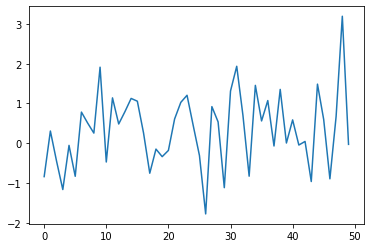

In [24]:
y = []
for i in range(1, len(x1)):
    y.append(x1[i] - x1[i-1])
    
plt.plot(y)
plt.show()

### Testing Stationarity
The stationarity of a series sometimes can be established by simply looking at its plot.
Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean and variance. If they are quite different then the series is not likely to be stationary.

Both these two techniques are not rigorous anyway, so a quantitative method to determine if a given series is stationary or not is needed. This can be done using statistical tests called \emph{unit root tests}. 
There are multiple implementations of such tests like:

* Augmented Dickey Fuller test (ADF Test)
* Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
* Philips Perron test (PP Test)

In the next Section we will focus on the ADF test.

## Augmented Dickey Fuller Test
Augmented Dickey Fuller (ADF) test is fundamentally a statistical significance test. That means, there is a hypothesis testing involved with a null and a alternate hypothesis and as a result a test statistic is computed and the corresponding p-values get reported.

It is from the test statistic and the p-value, an inference as to whether a given series is stationary or not can be made.

### Hypothesis Testing
Let's start with a simple example: imagine that you and your friend play a game. If a coin lands on heads, you win \$5 and if it lands on tails he wins \$5.

Let’s say the first two coin tosses landed on tails, meaning your friend won \$10. Should you be worried that he’s using a rigged coin ? Well, the probability of the coin landing on tails two times in a row is 25\% (0.5*0.5) which is not unlikely.

What if the coin landed on tails six times in a row ? The probability of that occurring is approximately 1.56\% ($0.5^6$), which is highly unlikely. At this point, it would be fair to assume that the coin is rigged. Typically, one would set a threshold, usually 5\%, to determine if an event occurred by chance or not (this threshold is usually reffered to as $\alpha$)

To understand hypothesis testing, let's describe some terminology:

* null hypothesis: the hypothesis that there is no significant difference between specified samples, any observed difference being due to sampling or experimental error;
* alternative hypothesis: the hypothesis that sample observations are influenced by some non-random cause;
* p-value: the probability of obtaining the observed results of a test, assuming that the null hypothesis is correct (i.e. a smaller p-value means that there is stronger evidence in favor of the alternative hypothesis);
* $\alpha$: the significance level; the probability of rejecting the null hypothesis when it is true (also known as type 1 error).

With the help of the previous example these terms can be clarified:

* the null hypothesis in our example is that the coin is a fair coin and that the observations are purely from chance;
* the alternative hypothesis would then be that the coin is not fair, and thus, the observations did not happen by chance;
* the p-value in the scenario of flipping tails 2 times in a row is 25\% and 6 times in a row is 1.56\%;
* the $\alpha$ or level of significance would be 5\%.

The main rule in determining whether you reject the null hypotesis is quite simple: \textbf{if the p-value is greater than $\alpha$, do not reject the null}.
In the case of flipping tails 2 times in a row, we would not reject the null since $25\% > 5\%$. However, in the case of flipping tails 6 times in a row, we would reject the null since $1.56\% < 5\%$.

These kind of tests is used to determine how likely or unlikely a hypothesis is for a given sample of data. The last part of the statement, \emph{for a given sample of data} is key because more often than not, you won’t be able to get an infinite amount of data or data that represents the entire population.

Here are the general steps to perform a hypothesis test:

* state your null and alternative hypotheses;
* set your significance level, $\alpha$. This is typically set at 5\% but can be set at other levels depending on the situation and how severe it is to committing a type 1 and/or 2 error (wrongly reject the null or wrongly accept the null);
* collect sample data and calculate sample statistics;
* calculate the p-value given the sample statistics. Most likely this will be done through the t-score or z-score; 
* reject or do not reject the null hypothesis.

### t-Score, z-Score
Z-score and t-score are both used in hypothesis testing.
The first one is calculated using the formula:
$$z = \frac{X-\mu}{\sigma}$$
where $\sigma$ is the population standard deviation and $\mu$ is the population mean. From the definition it is clear that this score can be used when the standard deviation of the population is known. Furthermore it is recommended to have a sample size of at least 30.

Conversely t-scores are used when you don’t know the population standard deviation; and you can only make an estimate by using your sample:
$$t = \frac{X – \mu}{s/\sqrt{n}}$$
where $s$ is the standard deviation of the sample and $n$ the sample size.


METTERE IN FONDO
Everitt, B. S.; Skrondal, A. (2010), The Cambridge Dictionary of Statistics, Cambridge University Press.
Gonick, L. (1993). The Cartoon Guide to Statistics. HarperPerennial.
Meier et. al. (2014). Applied Statistics for Public and Nonprofit Administration. Cengage Learning.
SoSci. (1999). Article posted on Vermont Tech website. Retrieved 11/20/2016 from https://simon.cs.vt.edu/SoSci/converted/T-Dist/.

### Unit Root Test
Unit root is a characteristic of a time series that makes it non-stationary. Technically speaking, a unit root is said to exist in a time series when the value $\beta_1 = 1$ in the equation below

$$Y_t = \beta_1 Y_{t-1} + \epsilon_t$$
where, $Y_t$ is the value of the time series at time $t$.This is a particular way of representing a time series that will be studied deeply in the following Sections.

The presence of a unit root means the time series is non-stationary and more generally, the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary.

### Dickey-Fuller Test
Before going into ADF test, let’s first understand what is the Dickey-Fuller test.

A Dickey-Fuller test is a unit root test that tests the null hypothesis that $\beta_1 =1$ in the following model equation.

$$\textrm{null hypothesis (H0)}:= \beta_1 =1$$

$$Y_t = c + \beta_0 t + \beta_1 Y_{t-1} + \phi\Delta Y_{t-1} + \epsilon_t$$

where, $Y_{t-1}$ = lag1 of time series, $\Delta Y_{t-1}$ = first difference of the series at time $(t-1)$.
Fundamentally, it has a similar null hypothesis as the unit root test, that is, the coefficient of $Y_{t-1}$ is 1, implying the presence of a unit root. If not rejected, the series is taken to be non-stationary.

### Augmented Dickey Fuller (ADF) Test
As the name suggest, the ADF test is an \emph{augmented} version of the Dickey Fuller test.

The ADF test expands the Dickey-Fuller test equation to include high order regressive process in the model.

$$Y_t = c + \beta_0 t + \beta_1 Y_{t-1} + \phi_1 \Delta Y_{t-1} + \phi_2 \Delta Y_{t-2} + \ldots + \phi_p \Delta Y_{t-p} + \epsilon_t$$

If you notice, we have only added more differencing terms, while the rest of the equation remains the same. This adds more thoroughness to the test.
The null hypothesis however is still the same as the Dickey Fuller test.

A key point to remember here is: since the null hypothesis assumes the presence of unit root, that is $\beta_1 =1$, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis, thereby, inferring that the series is stationary.

### ADF Test in Python
The \texttt{statsmodel} package provides a reliable implementation of the ADF test via the $\tt{adfuller()}$ function in \texttt{statsmodels.tsa.stattools}. 

In [25]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.145185689306739
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476


## Autocorrelation and Partial Autocorrelation Functions

### Autocorrelation

Autocorrelation is simply the correlation of a series with its own \emph{lags} (the previous values of the series). If a series is significantly autocorrelated, that means, the lags may be helpful in predicting the current value.

We can use statistical measures to calculate the correlation between the output variable and values at previous time steps (i.e. at various different lags). Again, because the correlation is calculated between the variable and itself at previous time steps, it is called an \emph{autocorrelation}. 

### Lag Plots
A lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series like the one you see below, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

\texttt{Pandas} provides a built-in plot to do exactly this, called the \texttt{lag_plot()} function.

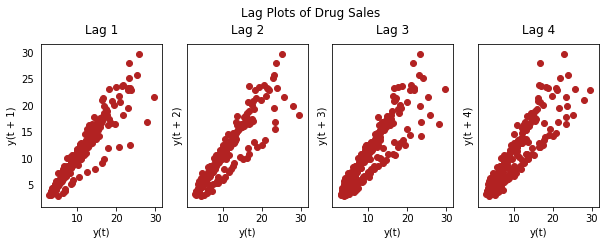

In [27]:
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

Another quick check that we can do is to directly calculate the correlation between the observation and the lag variable.

Correlation can be calculated easily using the \textt{corr()} function on the \texttt{DataFrame} of the lagged dataset.

In [34]:
from pandas import concat

dataframe = concat([df['value'].shift(-4), df[4:]['value']], axis=1)
dataframe.columns = ['t-4', 't']
result = dataframe.corr()
print(result)

          t-1         t
t-1  1.000000  0.878839
t    0.878839  1.000000


This is a good confirmation for the plot above. It shows a strong positive correlation (0.88) between the observation and the lag=4 value.

### Autocorrelation Plots
The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

We could plot the correlation coefficient for each lag variable, but it is tedious if we want to check a large number of variables in our time series..
Thankfully, \texttt{pandas} provides a built-in plot called the \textt{autocorrelation_plot()} function.

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

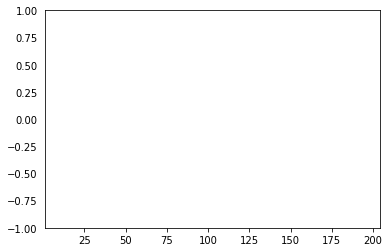

In [46]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df.values)

The \texttt{statsmodels} library also provides a version of the plot in the \texttt{plot_acf()} function as a line plot.

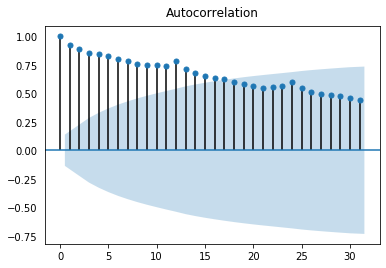

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['value'], lags=31)
plt.show()

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot can also be called a correlogram.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluctuation.

[1.         0.92056815 0.88782519 0.85385862 0.84052841 0.82523769
 0.79629658 0.77950157 0.75953251 0.74337588 0.74521347 0.74134847
 0.78031252 0.71424686 0.68014097 0.65401657 0.63791893 0.62349882
 0.60171747 0.58230335 0.5638103 ]


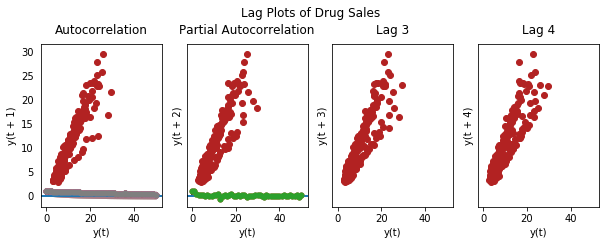

In [49]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print (acf(df.value, nlags=20))
# pacf_50 = pacf(df.value, nlags=50)

plot_acf(df.value.tolist(), lags=50, ax=axes[0])
#plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

### Partial Autocorrelation Function

Partial Autocorrelation also conveys similar information to ACF but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

The partial autocorrelation of lag $(k)$ of a series is the coefficient of that lag in the autoregression equation of $Y$. The autoregressive equation of $Y$ is nothing but the linear regression of $Y$ with its own lags as predictors.

For example, if $Y_t$ is the current series and $Y_{t-1}$ is the lag 1 of $Y$, then the partial autocorrelation of lag 3 $(Y_{t-3})$ is the coefficient $\beta_3$ of $Y_{t-3}$ in the following equation:

$$Y_t = \beta_0 + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \beta_3 Y_{t-3} + \ldots$$





But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

So what is the formula for PACF mathematically?

Partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.

$$Yt = \beta_0 + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \beta_3 Y_{t-3} + \ldots$$

That is, suppose, if $Y_t$ is the current series and $Y_{t-1}$ is the lag 1 of $Y$, then the partial autocorrelation of lag 3 ($Y_{t-3}$) is the coefficient $\beta_3$ of $Y_{t-3}$ in the above equation.



In [52]:
from matplotlib import pyplot
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

print (pacf(df.value, nlags=20))

plot_pacf(df.value.tolist(), lags=50, ax=axes[1])
pyplot.show()

[ 1.          0.92510297  0.28297106  0.0759758   0.16921494  0.09370324
 -0.06396075  0.0560044   0.01650882  0.00431904  0.17496764  0.08742467
  0.41635623 -0.63684013 -0.15223434  0.10337984 -0.10246178  0.04619914
  0.26331492 -0.06447131 -0.05881505]


## Intuition for ACF and PACF Plots
Plots of the autocorrelation function and the partial autocorrelation function for a time series tell a very different story.

We can use the intuition for ACF and PACF above to explore some thought experiments.

### Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

### Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

## Cointegration

A cointegration test is used to establish if there is a correlation between several time series in the long term. The concept was first introduced by Robert Engle and Clive Granger, in 1987.

Cointegration tests identify scenarios where two or more non-stationary time series are integrated together in a way that they cannot deviate from equilibrium in the long term. The tests are used to identify the degree of sensitivity of two variables to the same average price over a specified period of time.

Before the introduction of cointegration tests, economists relied on linear regressions to find the relationship between several time series processes. However, Granger and Newbold argued that linear regression was an incorrect approach for analyzing time series due to the possibility of producing spurious correlation. A spurious correlation occurs when two or more associated variables are deemed causally related due to either a coincidence or an unknown third factor. A possible result is a misleading statistical relationship between several time series variables.

### Methods of Testing for Cointegration
There are three main methods of testing for cointegration. They are used to identify the long-term relationships between two or more sets of variables. The methods include:

#### Engle-Granger Two-Step Method
The Engle-Granger Two-Step method starts by creating residuals based on the static regression and then testing the residuals for the presence of unit roots. It uses the Augmented Dickey-Fuller Test (ADF) or other tests to test for stationarity units in time series. If the time series is cointegrated, the Engle-Granger method will show the stationarity of the residuals.

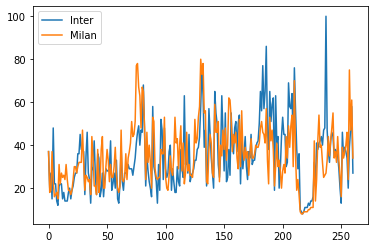

In [8]:
# takes two series, regress one on the other and perform a ADF test on the residuals
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("milan_inter.csv")

plt.plot(df['inter'], label='Inter')
plt.plot(df['milan'], label='Milan')
plt.legend()
plt.show()

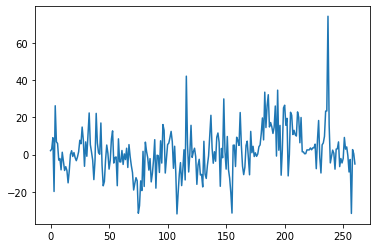

test statistic: -6.105445934885003
p-value: 9.609589483490934e-08
alpha 5% (-2.8728086526320302)


In [30]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

ls = sm.OLS(df['inter'], df['milan'])
res = ls.fit()

plt.plot(res.resid)
plt.show()

r = adfuller(res.resid)
print ("test statistic: {}".format(r[0]))
print ("p-value: {}".format(r[1]))
print ("alpha 5% ({})".format(r[4]['5%']))

### Granger Causality
Granger causality test is used to determine if one time series will be useful to forecast another.

It is based on the idea that if X causes Y, then the forecast of Y based on previous values of Y AND the previous values of X should outperform the forecast of Y based on previous values of Y alone.

So, understand that Granger causality should not be used to test if a lag of Y causes Y. Instead, it is generally used on exogenous (not Y lag) variables only.

It is nicely implemented in the statsmodel package.

It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor (X) is in the second column.

The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. If the P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said lag of X is indeed useful.

The second argument maxlag says till how many lags of Y should be included in the test.


## Introduction to ARIMA Models
ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: $p$, $d$, $q$ where,

* $p$ is the order of the AR term;
* $q$ is the order of the MA term;
* $d$ is the number of differencing required to make the time series stationary.

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

Let’s first look at the $d$ term.

### What does the $p$, $d$ and $q$ in ARIMA model mean
The first step to build an ARIMA model is to make the time series stationary, because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of $d$, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then $d = 0$.

$p$ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of $Y$ to be used as predictors. And $q$ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.


An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:

$$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \ldots + \phi_q \epsilon_{t-q}$$

ARIMA model in words:

Predicted $Y_t$ = Constant + Linear combination Lags of $Y$ (upto $p$ lags) + Linear Combination of Lagged forecast errors (upto $q$ lags)

The objective, therefore, is to identify the values of $p$, $d$ and $q$. 

### How to find the order of differencing $(d)$ in ARIMA model

The purpose of differencing is to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

So how to determine the right order of differencing?

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

Let’s see how to do it with an example.

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test ($\tt{adfuller()}$), from the $\tt{statsmodels}$ package because, you need differencing only if the series is non-stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if p-value > 0.05 we go ahead with finding the order of differencing.

In [3]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


Since p-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like

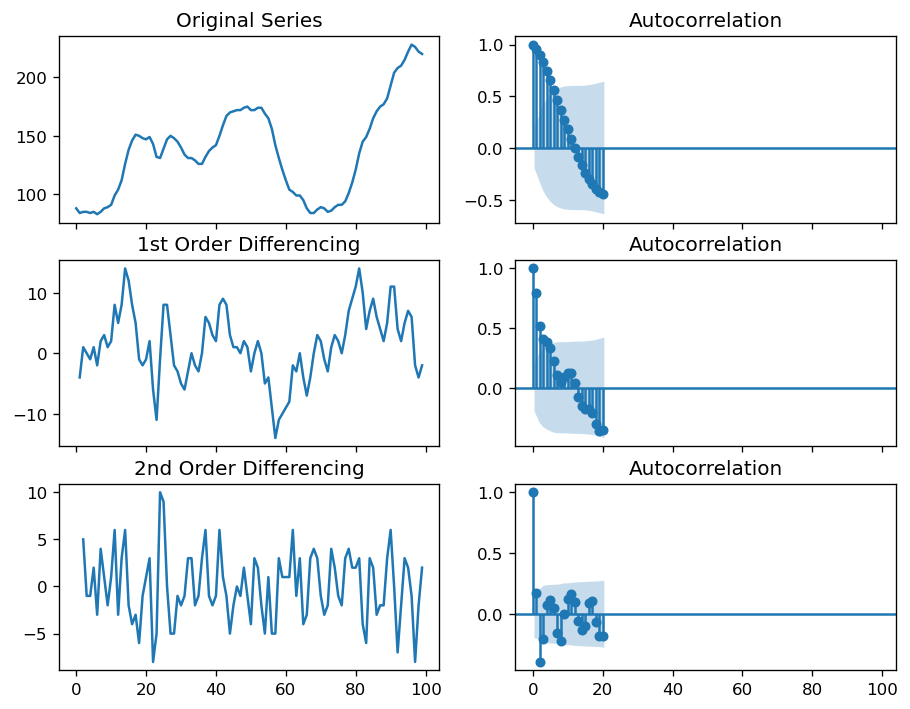

In [2]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

In [4]:
from pmdarima.arima.utils import ndiffs
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.value

## Adf Test
ndiffs(y, test='adf')  # 2

ModuleNotFoundError: No module named 'pmdarima'

How to find the order of the AR term (p)
The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.


Good. Now, how to find the number of AR terms?

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

AttributeError: 'DataFrame' object has no attribute 'value'

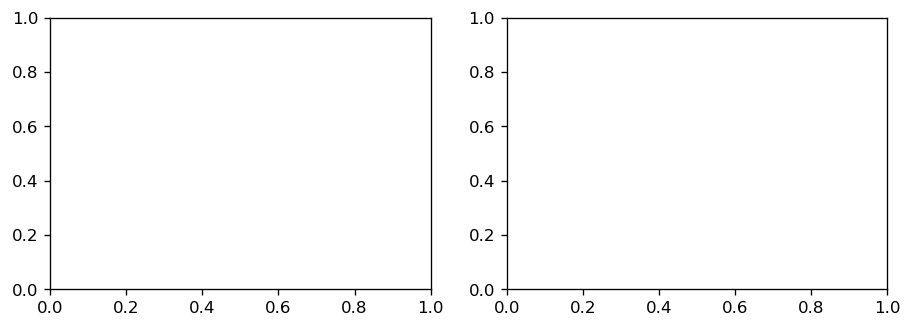

In [31]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])
plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the $p$ as 1.

7. How to find the order of the MA term (q)
Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.



In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/austa.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

# Time Series Forecasting

Forecasting is the next step where you want to predict the future values the series is going to take.
Forecasting a time series (like demand and sales) is often of tremendous commercial value.

In most manufacturing companies, it drives the fundamental business planning, procurement and production activities. Any errors in the forecasts will ripple down throughout the supply chain or any business context for that matter. So it’s important to get the forecasts accurate in order to save on costs and is critical to success.

Not just in manufacturing, the techniques and concepts behind time series forecasting are applicable in any business.

Now forecasting a time series can be broadly divided into two types.
If you use only the previous values of the time series to predict its future values, it is called Univariate Time Series Forecasting.

And if you use predictors other than the series (a.k.a exogenous variables) to forecast it is called Multi Variate Time Series Forecasting.

In the following we are going to, briefly, show various classical time series forecasting models.

### Autoregression (AR)

A regression model, such as linear regression, models an output value based on a linear combination of input values (see CAPM discussion). For example:

$$\hat{y} = b_0 + b_1*X_1$$
where $\hat{y}$ is the prediction, $b_0$ and $b_1$ are coefficients found by optimizing the model on training data, and $X$ is an input value.

This technique can be used on time series where input variables are taken as observations at previous time steps, called \emph{lag variables}.

For example, we can predict the value for the next time step $(t+1)$ given the observations at the last two time steps ($t-1$ and $t-2$). As a regression model, this would look as follows:

$$X_{t+1} = b_0 + b_1*X_{t-1} + b_2*X_{t-2}$$

Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self).

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

A pure Auto Regressive (AR only) model is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the ‘lags of $Y_t$’.

$$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + \epsilon_1$$

where, $Y_{t-1}$ is the lag1 of the series, $\beta_1$ is the coefficient of lag1 that the model estimates and $\alpha$ is the intercept term, also estimated by the model.


The notation for the model involves specifying the order of the model $p$ as a parameter to the AR function, e.g. AR($p$). For example, AR(1) is a first-order autoregression model.

The method is suitable for univariate time series without trend and seasonal components.

The correlation statistics can also help to choose which lag variables will be useful in a model and which will not. Interestingly, if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable. This can be very useful when getting started on a new dataset.

In [7]:
from statsmodels.tsa.ar_model import AutoReg
from random import random

data = [x + random() for x in range(1, 100)]

model = AutoReg(data, lags=1)
model_fit = model.fit()

yhat = model_fit.predict(len(data), len(data))
print(yhat)

[100.87201776]


/home/sani/anaconda3/envs/.python3/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


### Moving Average (MA)
The moving average (MA) method models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.

A moving average model is different from calculating the moving average of the time series.

The notation for the model involves specifying the order of the model q as a parameter to the MA function, e.g. MA(q). For example, MA(1) is a first-order moving average model.

The method is suitable for univariate time series without trend and seasonal components.

Python Code
We can use the ARIMA class to create an MA model and setting a zeroth-order AR model. We must specify the order of the MA model in the order argument.

Likewise a pure Moving Average (MA only) model is one where $Y_t$ depends only on the lagged forecast errors.

$$Y_t = \alpha + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \ldots + \phi_q \epsilon_{t-q}$$
where the error terms are the errors of the autoregressive models of the respective lags. The errors $\epsilon_t$ and $\epsilon{t-1}$ are the errors from the following equations:

$$Y_t = \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_0 Y_{0} + \epsilon_t$$
$$Y_{t-1} = \beta_2 Y_{t-2} + \beta_3 Y_{t-3} + \ldots + \beta_0 Y_{0} + \epsilon_{t-1}$$

In [8]:
# MA example
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(0, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)


[74.34708923]


/home/sani/anaconda3/envs/.python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Autoregressive Moving Average (ARMA)
The Autoregressive Moving Average (ARMA) method models the next step in the sequence as a linear function of the observations and residual errors at prior time steps.

It combines both Autoregression (AR) and Moving Average (MA) models.

The notation for the model involves specifying the order for the AR(p) and MA(q) models as parameters to an ARMA function, e.g. ARMA(p, q). An ARIMA model can be used to develop AR or MA models.

The method is suitable for univariate time series without trend and seasonal components.


In [9]:

# ARMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(2, 0, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)


[0.51643853]


/home/sani/anaconda3/envs/.python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


### Autoregressive Integrated Moving Average (ARIMA)
The Autoregressive Integrated Moving Average (ARIMA) method models the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps.

It combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I).

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function, e.g. ARIMA(p, d, q). An ARIMA model can also be used to develop AR, MA, and ARMA models.

The method is suitable for univariate time series with trend and without seasonal components.

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: $p$, $d$, $q$ where,

* $p$ is the order of the AR term;
* $q$ is the order of the MA term;
* $d$ is the number of differencing required to make the time series stationary.

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

Let’s first look at the $d$ term.

### What does the $p$, $d$ and $q$ in ARIMA model mean
The first step to build an ARIMA model is to make the time series stationary, because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of $d$, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then $d = 0$.

$p$ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of $Y$ to be used as predictors. And $q$ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.


An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:

$$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \ldots + \phi_q \epsilon_{t-q}$$

ARIMA model in words:

Predicted $Y_t$ = Constant + Linear combination Lags of $Y$ (upto $p$ lags) + Linear Combination of Lagged forecast errors (upto $q$ lags)

The objective, therefore, is to identify the values of $p$, $d$ and $q$. 

### How to find the order of differencing $(d)$ in ARIMA model

The purpose of differencing is to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

So how to determine the right order of differencing?

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

Let’s see how to do it with an example.

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test ($\tt{adfuller()}$), from the $\tt{statsmodels}$ package because, you need differencing only if the series is non-stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if p-value > 0.05 we go ahead with finding the order of differencing.

In [10]:
# ARIMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

[100.30068854]


### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
The Seasonal Autoregressive Integrated Moving Average (SARIMA) method models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.

It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function and AR(P), I(D), MA(Q) and m parameters at the seasonal level, e.g. SARIMA(p, d, q)(P, D, Q)m where “m” is the number of time steps in each season (the seasonal period). A SARIMA model can be used to develop AR, MA, ARMA and ARIMA models.

The method is suitable for univariate time series with trend and/or seasonal components.


In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

### Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)
The Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX) is an extension of the SARIMA model that also includes the modeling of exogenous variables.

Exogenous variables are also called covariates and can be thought of as parallel input sequences that have observations at the same time steps as the original series. The primary series may be referred to as endogenous data to contrast it from the exogenous sequence(s). The observations for exogenous variables are included in the model directly at each time step and are not modeled in the same way as the primary endogenous sequence (e.g. as an AR, MA, etc. process).

The SARIMAX method can also be used to model the subsumed models with exogenous variables, such as ARX, MAX, ARMAX, and ARIMAX.

The method is suitable for univariate time series with trend and/or seasonal components and exogenous variables.

In [11]:
# SARIMAX example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data1 = [x + random() for x in range(1, 100)]
data2 = [x + random() for x in range(101, 200)]
# fit model
model = SARIMAX(data1, exog=data2, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
exog2 = [200 + random()]
yhat = model_fit.predict(len(data1), len(data1), exog=[exog2])
print(yhat)

[100.35471348]


### Vector Autoregression (VAR)
The Vector Autoregression (VAR) method models the next step in each time series using an AR model. It is the generalization of AR to multiple parallel time series, e.g. multivariate time series.

The notation for the model involves specifying the order for the AR(p) model as parameters to a VAR function, e.g. VAR(p).

The method is suitable for multivariate time series without trend and seasonal components.


In [ ]:
# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = i + random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
# fit model
model = VAR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)


### Vector Autoregression Moving-Average (VARMA)
The Vector Autoregression Moving-Average (VARMA) method models the next step in each time series using an ARMA model. It is the generalization of ARMA to multiple parallel time series, e.g. multivariate time series.

The notation for the model involves specifying the order for the AR(p) and MA(q) models as parameters to a VARMA function, e.g. VARMA(p, q). A VARMA model can also be used to develop VAR or VMA models.

The method is suitable for multivariate time series without trend and seasonal components.


In [12]:
# VARMA example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
# fit model
model = VARMAX(data, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast()
print(yhat)

/home/sani/anaconda3/envs/.python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


[[0.52387293 1.02383584]]


/home/sani/anaconda3/envs/.python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.

8. How to handle if a time series is slightly under or over differenced
It may so happen that your series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

How to handle this case?

If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

9. How to build the ARIMA Model
Now that you’ve determined the values of p, d and q, you have everything needed to fit the ARIMA model. Let’s use the ARIMA() implementation in statsmodels package.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

Notice here the coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

So, let’s rebuild the model without the MA2 term.

In [ ]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

When you set dynamic=False the in-sample lagged values are used for prediction.

That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

So, we seem to have a decent ARIMA model. But is that the best?

Can’t say that at this point because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

So, the real validation you need now is the Out-of-Time cross-validation.

10. How to do find the optimal ARIMA model manually using Out-of-Time Cross validation
In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Why am I not sampling the training data randomly you ask?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

You can now build the ARIMA model on training dataset, forecast and plot it.

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

So, what I am going to do is to increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

While doing this, I keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05.

In [ ]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The AIC has reduced to 440 from 515. Good. The P-values of the X terms are less the < 0.05, which is great.

So overall it’s much better.

Ideally, you should go back multiple points in time, like, go back 1, 2, 3 and 4 quarters and see how your forecasts are performing at various points in the year.

Here’s a great practice exercise: Try to go back 27, 30, 33, 36 data points and see how the forcasts performs. The forecast performance can be judged using various accuracy metrics discussed next.

11. Accuracy Metrics for Time Series Forecast
The commonly used accuracy metrics to judge forecasts are:

Mean Absolute Percentage Error (MAPE)
Mean Error (ME)
Mean Absolute Error (MAE)
Mean Percentage Error (MPE)
Root Mean Squared Error (RMSE)
Lag 1 Autocorrelation of Error (ACF1)
Correlation between the Actual and the Forecast (corr)
Min-Max Error (minmax)
Typically, if you are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.

Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.

The other error metrics are quantities. That implies, an RMSE of 100 for a series whose mean is in 1000’s is better than an RMSE of 5 for series in 10’s. So, you can’t really use them to compare the forecasts of two different scaled time series.

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)


Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.

Now you know how to build an ARIMA model manually.

But in industrial situations, you will be given a lot of time series to be forecasted and the forecasting exercise be repeated regularly.

So we need a way to automate the best model selection process.

12. How to do Auto Arima Forecast in Python
Like R’s popular auto.arima() function, the pmdarima package provides auto_arima() with similar functionality.

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


How to interpret the residual plots in ARIMA model
Let’s review the residual plots using stepwise_fit.

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

So how to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s forecast.

In [ ]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

How to automatically build SARIMA model in python
The problem with plain ARIMA model is it does not support seasonality.

If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.

If your model has well defined seasonal patterns, then enforce D=1 for a given frequency ‘x’.

Here’s some practical advice on building SARIMA model:

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR or SMA terms if your model has seasonal components.

Let’s build an SARIMA model on 'a10' – the drug sales dataset.

In [ ]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

As you can clearly see, the seasonal spikes is intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

Let’s build the SARIMA model using pmdarima‘s auto_arima(). To do that, you need to set seasonal=True, set the frequency m=12 for month wise series and enforce D=1.

In [ ]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

The model has estimated the AIC and the P values of the coefficients look significant. Let’s look at the residual diagnostics plot.

The best model SARIMAX(3, 0, 0)x(0, 1, 1, 12) has an AIC of 528.6 and the P Values are significant.

Let’s forecast for the next 24 months.

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

How to build SARIMAX Model with exogenous variable
The SARIMA model we built is good. I would stop here typically.

But for the sake of completeness, let’s try and force an external predictor, also called, ‘exogenous variable’ into the model. This model is called the SARIMAX model.

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

For the sake of demonstration, I am going to use the seasonal index from the classical seasonal decomposition on the latest 36 months of data.

Why the seasonal index? Isn’t SARIMA already modeling the seasonality, you ask?

You are correct.

But also, I want to see how the model looks if we force the recent seasonality pattern into the training and forecast.

Secondly, this is a good variable for demo purpose. So you can use this as a template and plug in any of your variables into the code. The seasonal index is a good exogenous variable because it repeats every frequency cycle, 12 months in this case.

So, you will always know what values the seasonal index will hold for the future forecasts.

In [ ]:
# Import Data
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

Let’s compute the seasonal index so that it can be forced as a (exogenous) predictor to the SARIMAX model.

In [ ]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

The exogenous variable (seasonal index) is ready. Let’s build the SARIMAX model.

In [ ]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

So, we have the model with the exogenous term. But the coefficient is very small for x1, so the contribution from that variable will be negligible. Let’s forecast it anyway.

We have effectively forced the latest seasonal effect of the latest 3 years into the model instead of the entire history.

Alright let’s forecast into the next 24 months. For this, you need the value of the seasonal index for the next 24 months.

In [ ]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

Practice Exercises
In the AirPassengers dataset, go back 12 months in time and build the SARIMA forecast for the next 12 months.

Is the series stationary? If not what sort of differencing is required?
What is the order of your best model?
What is the AIC of your model?
What is the MAPE achieved in OOT cross-validation?
What is the order of the best model predicted by auto_arima() method?

### Persistence Model
Let’s say that we want to develop a model to predict the last 7 days of minimum temperatures in the dataset given all prior observations.

The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

We can develop a test harness for the problem by splitting the observations into training and test sets, with only the last 7 observations in the dataset assigned to the test set as “unseen” data that we wish to predict.

The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next day. This means that we are not making a 7-day forecast, but 7 1-day forecasts.

Test MSE: 3.423


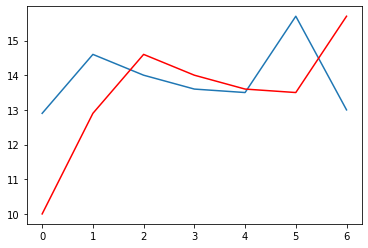

In [11]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
series = read_csv('daily-min-temperatures.csv', header=0, index_col=0)
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Running the example prints the mean squared error (MSE). The value provides a baseline performance for the problem.
The expected values for the next 7 days are plotted (blue) compared to the predictions from the model (red).

### Autoregression Model
An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class.

We can use this model by first creating the model AutoReg() and then calling fit() to train it on our dataset. This returns an AutoRegResults object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 1 7-day forecast, which is different from the persistence example above.

/home/sani/anaconda3/envs/.python3/lib/python3.6/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


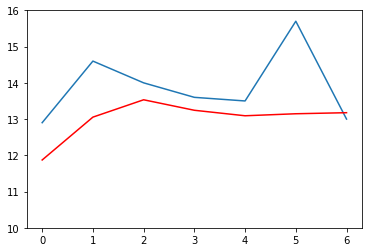

In [3]:
# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.ylim(10,16)
pyplot.plot(predictions, color='red')
pyplot.show()